In [7]:
require(dplyr)
require(ggpubr)
require(data.table)
library(tidyverse)
options(warn = -1)

**Parameters**

In [8]:
# Inputs
inputpath_perez2022 <- "data/Compare_SLE_subgroups/STAT1_SP1_perez2022_level1.csv"
inputpath_scgt00 <- "data/Compare_SLE_subgroups/STAT1_SP1_scgt00_level1.csv"

inputpath_perez2022_level2 <- "data/Compare_SLE_subgroups/STAT1_SP1_perez2022_Level2.csv"
inputpath_scgt00_level2 <- "data/Compare_SLE_subgroups/STAT1_SP1_scgt00_Level2.csv"

# Outputs
outputpath <- "results/"

# Palette
color_palette_path <- "data/colors_palette.R"
source(color_palette_path)

# Load data

In [9]:
perez2022_level1 <- read.csv(inputpath_perez2022, header = TRUE)
scgt00_level1 <- read.csv(inputpath_scgt00, header = TRUE)

perez2022_level2 <- read.csv(inputpath_perez2022_level2, header = TRUE)
scgt00_level2 <- read.csv(inputpath_scgt00_level2, header = TRUE)

# Paper figures

## Flare comparison

In [10]:
tf_order <- c("STAT1", "SP1")
l1_cell_type_order <- names(cell_colors)
l2_cell_type_order <- names(cell_level2_colors)

In [11]:
flare_palette <- c(
  "F" = "#e76f51",
  "notF" = "#e9c46a"
)

In [12]:
data_flare_level2 <-
    perez2022_level2 %>%
    mutate(
        Flare = case_when(Flare == "not_F" ~ "notF",
        TRUE ~ as.character(Flare))
    ) %>%
    filter(
        Flare %in% c("notF", "F")
    ) %>%
    tidyr::pivot_longer(
        cols = c(STAT1, SP1),
        names_to = "TF",
        values_to = "activity"
        ) %>%
    filter(
        !is.na(activity),
        #Level1 %in% pvals_flare$Level1
    ) %>%
  mutate(
    Level1 = factor(Level1, levels = l1_cell_type_order),
    Level2 = factor(Level2, levels = l2_cell_type_order),
    TF = factor(TF, levels = tf_order)
  )


In [14]:
flare_counts <- data_flare_level2 %>%
  group_by(Level2, Flare) %>%
  summarise(sample_count = n_distinct(sampleID)) %>%
  filter(sample_count >= 3) %>%
  group_by(Level2) %>%
  filter(all(c("F", "notF") %in% Flare)) %>%
  ungroup()
level2_categories <- unique(flare_counts$Level2)
level2_categories

`summarise()` has grouped output by 'Level2'. You can override using the `.groups` argument.


[1] Mono_classical      Mono_nonClassical   Mono_inflammatory  
 [4] Mono_IFNresponse    T_CD4_Naive         T_CD8_Naive        
 [7] T_CD8_CM            T_CD8_CM_stem       T_CD8_EM_CX3CR1high
[10] T_CD8_EM_CX3CR1int  T_CD8_eff_HOBIT     T_CD8_IFNresponse  
[13] T_CD8_Mem_cytotoxic T_CD8_activated     NK_CD56dimCD16     
[16] NK_CD56high         NK_adaptive         NK_lowRibocontent  
64 Levels: B_Transitional B_Naive B_Naive_activated ... HBcell

In [15]:
mean_activity_df <- data_flare_level2 %>%
  group_by(level_1, Level1, Level2, TF, Flare) %>%
  summarize(mean_activity = mean(activity, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(level_1_TF = paste(level_1, TF, sep = "_")) %>%
  column_to_rownames(var = "level_1_TF") %>%
  filter(Level2 %in% level2_categories)


`summarise()` has grouped output by 'level_1', 'Level1', 'Level2', 'TF'. You can override using the `.groups` argument.


In [16]:
mean_activity_df <-  mean_activity_df %>%
  group_by(TF) %>%     
  mutate(mean_activity_processed = mean_activity + abs(min(mean_activity, na.rm = TRUE))) %>%
  mutate(TF_normalized_mean_activity = (mean_activity_processed - min(mean_activity_processed, na.rm = TRUE)) / diff(range(mean_activity_processed, na.rm = TRUE))) %>%
  ungroup()

In [17]:
heatmap_df <- mean_activity_df %>%
  mutate(Flare_TF = paste(Flare, TF, sep = "_")) %>%
  group_by(Flare_TF, TF, Level2) %>%
  summarize(mean_activity = mean(mean_activity, na.rm = TRUE), .groups = 'drop') %>%
  ungroup() %>% 
  group_by(TF) %>%   
  mutate(TF_normalized_mean_activity = (mean_activity - min(mean_activity, na.rm = TRUE)) / diff(range(mean_activity, na.rm = TRUE))) %>% 
  ungroup() %>% 
  group_by(Flare_TF, Level2) %>%
  summarize(mean_activity_norm = TF_normalized_mean_activity, .groups = 'drop')  %>% 
  pivot_wider(names_from = Level2, values_from = mean_activity_norm) %>%
  column_to_rownames(var = "Flare_TF")

In [18]:
col_annot <- mean_activity_df %>%
  select(Level2, Level1) %>%
  distinct() %>%
  {rownames(.) <- NULL; .} %>%
  arrange(match(Level2, names(cell_level2_colors))) %>%
  column_to_rownames(var = "Level2") 
col_annot$Level2 <- rownames(col_annot)
col_order <- rownames(col_annot)

In [19]:
row_annot <- mean_activity_df %>%
  select(TF, Flare) %>%
  distinct() %>%
  mutate(Flare_TF = paste(Flare, TF, sep = "_")) %>%
  {rownames(.) <- NULL; .} %>%
  column_to_rownames(var = "Flare_TF") %>%
  arrange(match(TF, tf_order))
row_order <- rownames(row_annot) 

In [20]:
my_colour_annot <- list(
    Flare = flare_palette,
    TF = tfs_colors[names(tfs_colors) %in% levels(row_annot$TF)],
    Level1 = cell_colors[names(cell_colors) %in% col_annot$Level1],
    Level2 = cell_level2_colors[names(cell_level2_colors) %in% col_annot$Level2]
)

In [22]:
figure_path = paste0(outputpath, "SP1_STAT1_heatmap.pdf")
pdf(figure_path, width = 15, height = 12)
Flare_heatmap <- pheatmap::pheatmap(
    heatmap_df[row_order, col_order],
    border_color = NA,
    na_col = "white",
    color = hcl.colors(50, "Plasma"),
    #breaks = my_breaks,
    annotation_colors = my_colour_annot,
    cluster_cols = FALSE,
    cluster_rows = FALSE,
    cellheight = 10,
    cellwidth = 10,
    annotation_col = col_annot,
    annotation_row = row_annot,
    cex = 1,
    fontsize = 9,
    labels_col = col_annot$disease,
    filename = figure_path,
    main = "IFN_response",
    gaps_col = c(4, 5, 6, 14), 
    gaps_row = c(2)
    )
print(Flare_heatmap)
dev.off()

pdf 
  4

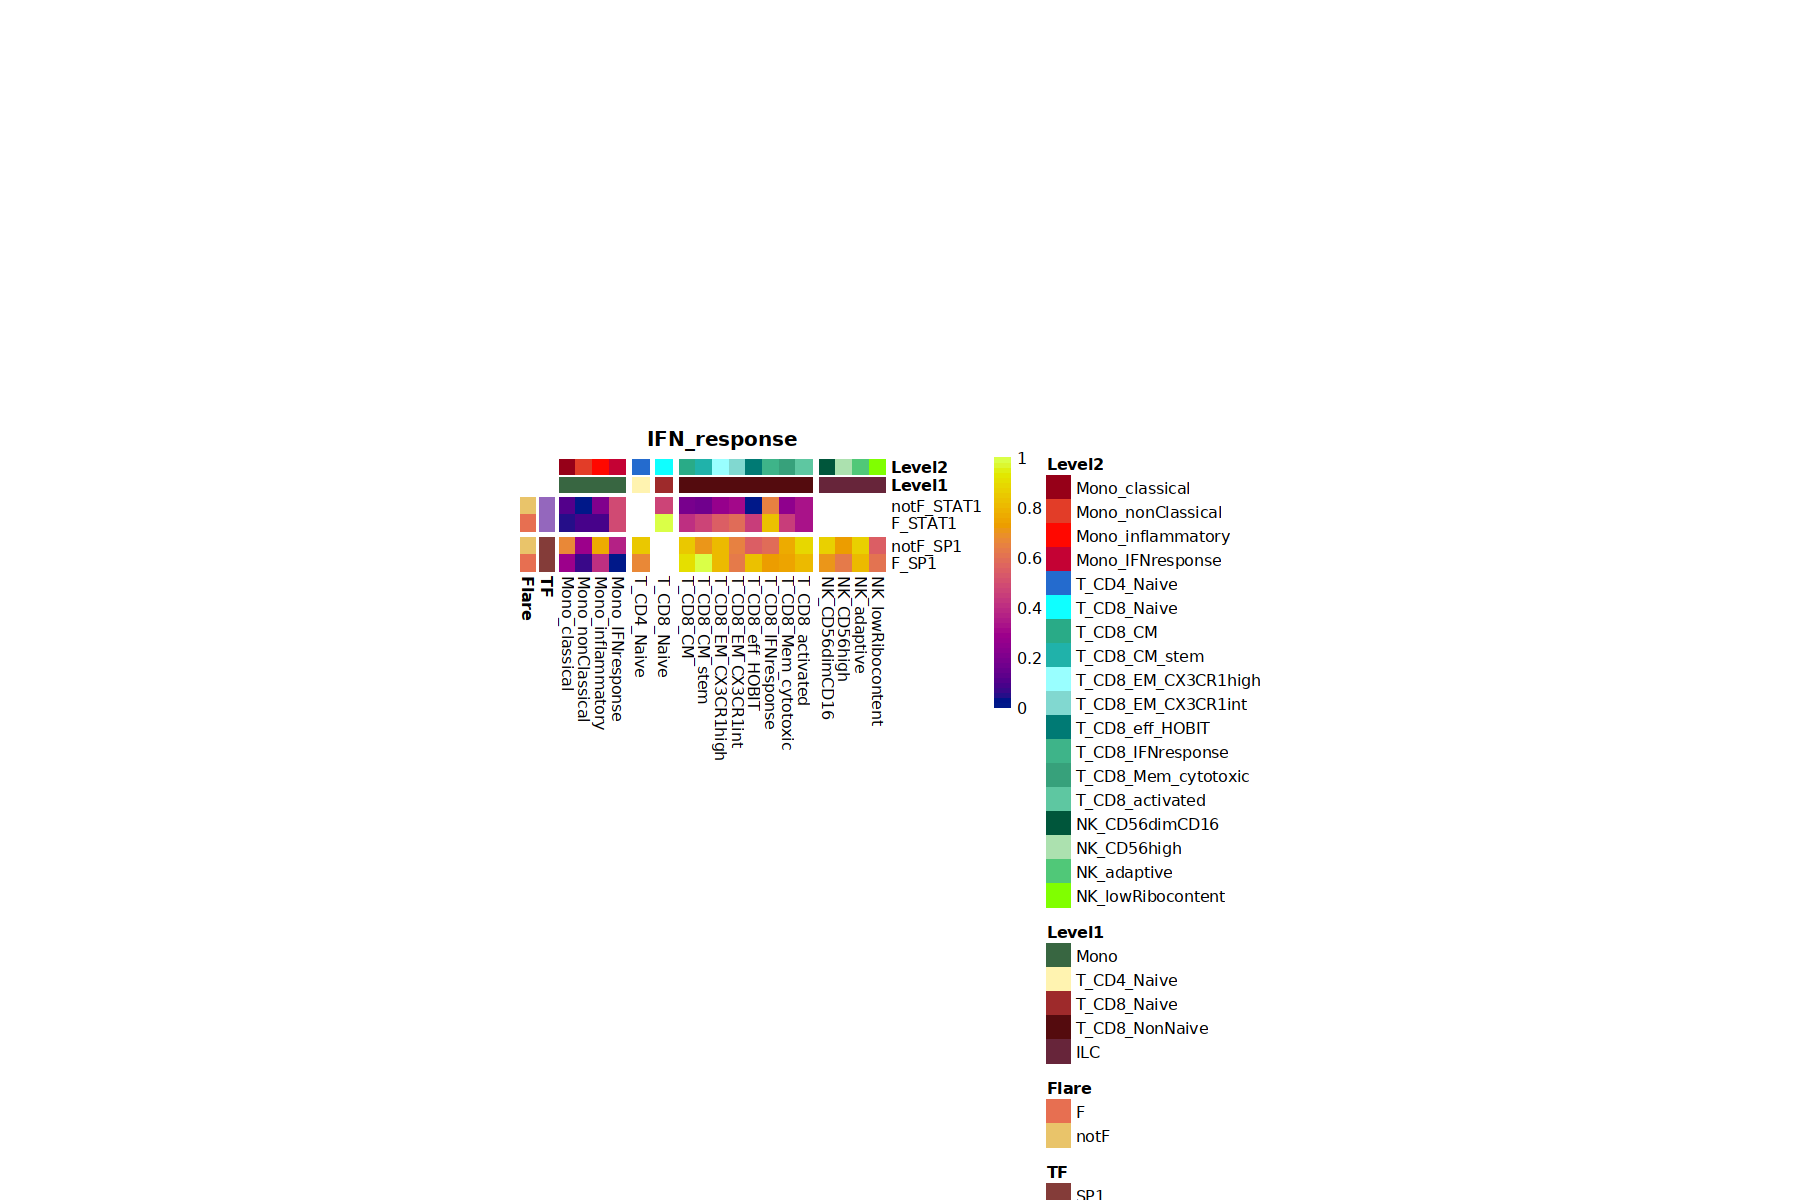

In [25]:
print(Flare_heatmap)